# Import and load Detectron2 and libraries

In [1]:
!nvidia-smi

Fri Jun 26 18:34:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:04:00.0 Off |                  N/A |
| 19%   38C    P0    71W / 250W |      0MiB / 12212MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 980 Ti  Off  | 00000000:05:00.0 Off |                  N/A |
| 22%   30C    P8    15W / 250W |   6016MiB /  6083MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import torch, torchvision
torch.cuda.set_device(3)
print(f'Torch version: {torch.__version__}')

Torch version: 1.4.0


In [3]:
# Restart runtime.
%load_ext autoreload
%autoreload 2

# Setup logger detectron2.
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common detectron2 utilities.
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.engine import DefaultPredictor, DefaultTrainer, LOFARTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LOFAREvaluator
from detectron2 import model_zoo ##### Auke: Is this necessary?


# Import some common libraries.
import numpy as np
from sys import argv
from cv2 import imread
import random
import os
import pickle
from operator import itemgetter
import matplotlib.pyplot as plt

# 1. Load data

In [13]:
# Setup dataset.
DATASET_NAME= "auke_set_29"
DATASET_PATH = f"/data/s1594443/data/frcnn_images_DR1/{DATASET_NAME}/LGZ_COCOstyle/annotations/"

In [14]:
# Setup cfg.
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/v8_faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_train",)
#cfg.DATASETS.TEST = (f"{DATASET_NAME}_test",)
cfg.DATASETS.TEST = (f"{DATASET_NAME}_train", f"{DATASET_NAME}_val", f"{DATASET_NAME}_test")
cfg.DATALOADER.NUM_WORKERS = 1
cfg.OUTPUT_DIR = './output/v29'
cfg.TEST.EVAL_PERIOD = 20
if os.path.exists(cfg.OUTPUT_DIR) == False: os.makedirs(cfg.OUTPUT_DIR)
#cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # Let training initialize from model zoo
#cfg.MODEL.WEIGHTS = None #"https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl"
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR,"model_0014999.pth")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0003  # pick a good LR
cfg.SOLVER.MAX_ITER = 200 # iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

In [15]:
def get_lofar_dicts(annotation_filepath):
    with open(annotation_filepath, "rb") as f:
        dataset_dicts = pickle.load(f)
    new_data = []
    for i in range(len(dataset_dicts)):
        for ob in dataset_dicts[i]['annotations']:
            ob['bbox_mode'] = BoxMode.XYXY_ABS
        if dataset_dicts[i]['file_name'].endswith('_rotated0deg.png'):
            new_data.append(dataset_dicts[i])
    return new_data

In [16]:
for d in ["train", "val", "test"]:
    DatasetCatalog.register(f"{DATASET_NAME}_" + d, 
                            lambda d=d: get_lofar_dicts(os.path.join(DATASET_PATH,f"VIA_json_{d}.pkl")))
    MetadataCatalog.get(f"{DATASET_NAME}_" + d).set(thing_classes=["radio_source"])
lofar_metadata = MetadataCatalog.get(f"{DATASET_NAME}_train")

AssertionError: Dataset 'auke_set_29_train' is already registered!

# 2. Inspect data.

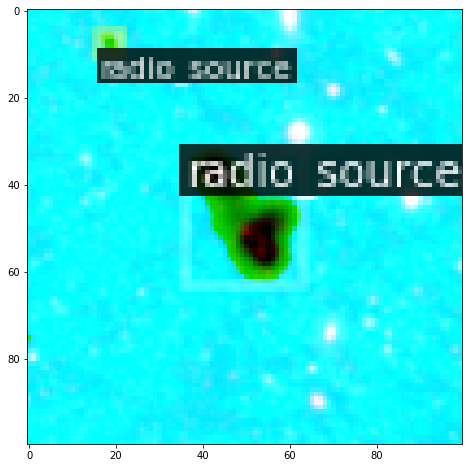

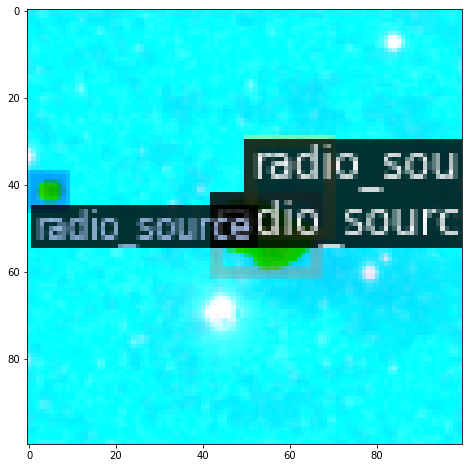

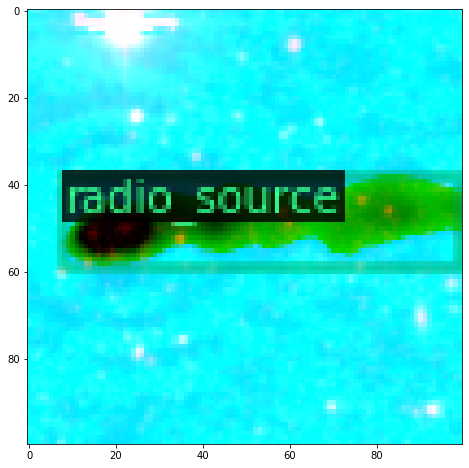

In [8]:
# Sample and plot input data as sanity check.
dataset_dicts = get_lofar_dicts(os.path.join(DATASET_PATH,"VIA_json_train.pkl"))
for i, d in enumerate(random.sample(dataset_dicts, 3)):
    img = imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=lofar_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    a= vis.get_image()[:, :, ::-1]
    plt.figure(figsize=(8,8))
    plt.imshow(a)
    plt.savefig(os.path.join(cfg.OUTPUT_DIR,f"random_input_example_for_sanity_check_{i}"))
    plt.show()
    plt.close()

# 3. Train data.

In [104]:
# Comment from Rafaël copies from train_lofar.py

# # Train mode

# To implement the LOFAR relevant metrics I changed
# DefaultTrainer into LOFARTrainer
# where the latter calls LOFAREvaluator within build_hooks instead of the default evaluator
# this works for the after the fact test eval
# for train eval those things are somewhere within a model 
# specifically a model that takes data and retuns a dict of losses

In [17]:
# Load model.
trainer = LOFARTrainer(cfg) 

[06/26 18:48:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[06/26 18:48:08 d2.data.build]: Removed 0 images with no usable annotations. 55 images left.
[06/26 18:48:08 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(200,), max_size=200, sample_style='choice'), RandomFlip()]
[06/26 18:48:08 d2.data.build]: Using training sampler TrainingSampler


In [9]:
# Make directory and set up model path.
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
pretrained_model_path = os.path.join(cfg.OUTPUT_DIR,"model_final.pth")

In [38]:
if os.path.exists(pretrained_model_path):
    print(f'Pretrained model path exists: {pretrained_model_path}')
    cfg.MODEL.WEIGHTS = pretrained_model_path
    trainer.resume_or_load(resume=True)
else:
    print(f'Pretrained model path does not exist. Will not resume training.')
    trainer.resume_or_load(resume=False)

Pretrained model path does not exist. Will not resume training.
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: Remapping C2 weights ......
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.bias            loaded from res2_0_branch2a_bn_b              of shape (256,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.running_mean    loaded from res2_0_branch2a_bn_rm             of shape (256,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.running_var     loaded from res2_0_branch2a_bn_riv            of shape (256,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.weight          loaded from res2_0_branch2a_bn_s              of shape (256,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.weight               loaded from res2_0_branch2a_w                 of shape (256, 64, 1, 1)
[06/26 18:27:37 d2.checkpoint.

[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.2.conv3.norm.running_var     loaded from res2_2_branch2c_bn_riv            of shape (256,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.2.conv3.norm.weight          loaded from res2_2_branch2c_bn_s              of shape (256,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.2.conv3.weight               loaded from res2_2_branch2c_w                 of shape (256, 256, 1, 1)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.conv1.norm.bias            loaded from res3_0_branch2a_bn_b              of shape (512,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.conv1.norm.running_mean    loaded from res3_0_branch2a_bn_rm             of shape (512,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.conv1.norm.running_var     loaded from res3_0_branch2a_bn_riv            of shape (512,)
[06/26

[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv2.weight               loaded from res3_2_branch2b_w                 of shape (512, 16, 3, 3)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv3.norm.bias            loaded from res3_2_branch2c_bn_b              of shape (512,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv3.norm.running_mean    loaded from res3_2_branch2c_bn_rm             of shape (512,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv3.norm.running_var     loaded from res3_2_branch2c_bn_riv            of shape (512,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv3.norm.weight          loaded from res3_2_branch2c_bn_s              of shape (512,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv3.weight               loaded from res3_2_branch2c_w                 of shape (512, 512, 1, 

[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv2.norm.running_mean    loaded from res4_1_branch2b_bn_rm             of shape (1024,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv2.norm.running_var     loaded from res4_1_branch2b_bn_riv            of shape (1024,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv2.norm.weight          loaded from res4_1_branch2b_bn_s              of shape (1024,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv2.weight               loaded from res4_1_branch2b_w                 of shape (1024, 32, 3, 3)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv3.norm.bias            loaded from res4_1_branch2c_bn_b              of shape (1024,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv3.norm.running_mean    loaded from res4_1_branch2c_bn_rm             of shape (1024,)
[

[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.conv2.norm.weight         loaded from res4_12_branch2b_bn_s             of shape (1024,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.conv2.weight              loaded from res4_12_branch2b_w                of shape (1024, 32, 3, 3)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.conv3.norm.bias           loaded from res4_12_branch2c_bn_b             of shape (1024,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.conv3.norm.running_mean   loaded from res4_12_branch2c_bn_rm            of shape (1024,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.conv3.norm.running_var    loaded from res4_12_branch2c_bn_riv           of shape (1024,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.conv3.norm.weight         loaded from res4_12_branch2c_bn_s             of shape (1024,)
[

[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.15.conv3.norm.bias           loaded from res4_15_branch2c_bn_b             of shape (1024,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.15.conv3.norm.running_mean   loaded from res4_15_branch2c_bn_rm            of shape (1024,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.15.conv3.norm.running_var    loaded from res4_15_branch2c_bn_riv           of shape (1024,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.15.conv3.norm.weight         loaded from res4_15_branch2c_bn_s             of shape (1024,)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.15.conv3.weight              loaded from res4_15_branch2c_w                of shape (1024, 1024, 1, 1)
[06/26 18:27:37 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.16.conv1.norm.bias           loaded from res4_16_branch2a_bn_b             of shape (1024,)

[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.18.conv3.norm.running_var    loaded from res4_18_branch2c_bn_riv           of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.18.conv3.norm.weight         loaded from res4_18_branch2c_bn_s             of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.18.conv3.weight              loaded from res4_18_branch2c_w                of shape (1024, 1024, 1, 1)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.19.conv1.norm.bias           loaded from res4_19_branch2a_bn_b             of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.19.conv1.norm.running_mean   loaded from res4_19_branch2a_bn_rm            of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.19.conv1.norm.running_var    loaded from res4_19_branch2a_bn_riv           of shape (1024,)

[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.20.conv3.weight              loaded from res4_20_branch2c_w                of shape (1024, 1024, 1, 1)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.21.conv1.norm.bias           loaded from res4_21_branch2a_bn_b             of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.21.conv1.norm.running_mean   loaded from res4_21_branch2a_bn_rm            of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.21.conv1.norm.running_var    loaded from res4_21_branch2a_bn_riv           of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.21.conv1.norm.weight         loaded from res4_21_branch2a_bn_s             of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.21.conv1.weight              loaded from res4_21_branch2a_w                of shape (1024, 

[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv1.norm.running_mean    loaded from res4_4_branch2a_bn_rm             of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv1.norm.running_var     loaded from res4_4_branch2a_bn_riv            of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv1.norm.weight          loaded from res4_4_branch2a_bn_s              of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv1.weight               loaded from res4_4_branch2a_w                 of shape (1024, 1024, 1, 1)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv2.norm.bias            loaded from res4_4_branch2b_bn_b              of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv2.norm.running_mean    loaded from res4_4_branch2b_bn_rm             of shape (1024,)

[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv1.norm.weight          loaded from res4_7_branch2a_bn_s              of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv1.weight               loaded from res4_7_branch2a_w                 of shape (1024, 1024, 1, 1)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv2.norm.bias            loaded from res4_7_branch2b_bn_b              of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv2.norm.running_mean    loaded from res4_7_branch2b_bn_rm             of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv2.norm.running_var     loaded from res4_7_branch2b_bn_riv            of shape (1024,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv2.norm.weight          loaded from res4_7_branch2b_bn_s              of shape (1024,)

[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.conv2.norm.bias            loaded from res5_0_branch2b_bn_b              of shape (2048,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.conv2.norm.running_mean    loaded from res5_0_branch2b_bn_rm             of shape (2048,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.conv2.norm.running_var     loaded from res5_0_branch2b_bn_riv            of shape (2048,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.conv2.norm.weight          loaded from res5_0_branch2b_bn_s              of shape (2048,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.conv2.weight               loaded from res5_0_branch2b_w                 of shape (2048, 64, 3, 3)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.conv3.norm.bias            loaded from res5_0_branch2c_bn_b              of shape (2048,)
[

[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.stem.conv1.norm.running_var       loaded from res_conv1_bn_riv                  of shape (64,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.stem.conv1.norm.weight            loaded from res_conv1_bn_s                    of shape (64,)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.stem.conv1.weight                 loaded from conv1_w                           of shape (64, 3, 7, 7)
[06/26 18:27:38 d2.checkpoint.c2_model_loading]: Some model parameters or buffers are not in the checkpoint:
  backbone.fpn_lateral2.{bias, weight}
  backbone.fpn_lateral3.{bias, weight}
  backbone.fpn_lateral4.{bias, weight}
  backbone.fpn_lateral5.{bias, weight}
  backbone.fpn_output2.{bias, weight}
  backbone.fpn_output3.{bias, weight}
  backbone.fpn_output4.{bias, weight}
  backbone.fpn_output5.{bias, weight}
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
  proposal_generato

In [18]:
trainer.resume_or_load(resume=False)

[06/26 18:48:18 d2.checkpoint.c2_model_loading]: Remapping C2 weights ......
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.bias            loaded from res2_0_branch2a_bn_b              of shape (256,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.running_mean    loaded from res2_0_branch2a_bn_rm             of shape (256,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.running_var     loaded from res2_0_branch2a_bn_riv            of shape (256,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.weight          loaded from res2_0_branch2a_bn_s              of shape (256,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.weight               loaded from res2_0_branch2a_w                 of shape (256, 64, 1, 1)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv2.norm.bias    

[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.2.conv3.norm.running_var     loaded from res2_2_branch2c_bn_riv            of shape (256,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.2.conv3.norm.weight          loaded from res2_2_branch2c_bn_s              of shape (256,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.2.conv3.weight               loaded from res2_2_branch2c_w                 of shape (256, 256, 1, 1)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.conv1.norm.bias            loaded from res3_0_branch2a_bn_b              of shape (512,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.conv1.norm.running_mean    loaded from res3_0_branch2a_bn_rm             of shape (512,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.conv1.norm.running_var     loaded from res3_0_branch2a_bn_riv            of shape (512,)
[06/26

[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv2.weight               loaded from res3_2_branch2b_w                 of shape (512, 16, 3, 3)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv3.norm.bias            loaded from res3_2_branch2c_bn_b              of shape (512,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv3.norm.running_mean    loaded from res3_2_branch2c_bn_rm             of shape (512,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv3.norm.running_var     loaded from res3_2_branch2c_bn_riv            of shape (512,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv3.norm.weight          loaded from res3_2_branch2c_bn_s              of shape (512,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv3.weight               loaded from res3_2_branch2c_w                 of shape (512, 512, 1, 

[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv2.norm.running_mean    loaded from res4_1_branch2b_bn_rm             of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv2.norm.running_var     loaded from res4_1_branch2b_bn_riv            of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv2.norm.weight          loaded from res4_1_branch2b_bn_s              of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv2.weight               loaded from res4_1_branch2b_w                 of shape (1024, 32, 3, 3)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv3.norm.bias            loaded from res4_1_branch2c_bn_b              of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv3.norm.running_mean    loaded from res4_1_branch2c_bn_rm             of shape (1024,)
[

[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.conv2.norm.weight         loaded from res4_12_branch2b_bn_s             of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.conv2.weight              loaded from res4_12_branch2b_w                of shape (1024, 32, 3, 3)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.conv3.norm.bias           loaded from res4_12_branch2c_bn_b             of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.conv3.norm.running_mean   loaded from res4_12_branch2c_bn_rm            of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.conv3.norm.running_var    loaded from res4_12_branch2c_bn_riv           of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.12.conv3.norm.weight         loaded from res4_12_branch2c_bn_s             of shape (1024,)
[

[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.15.conv3.norm.bias           loaded from res4_15_branch2c_bn_b             of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.15.conv3.norm.running_mean   loaded from res4_15_branch2c_bn_rm            of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.15.conv3.norm.running_var    loaded from res4_15_branch2c_bn_riv           of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.15.conv3.norm.weight         loaded from res4_15_branch2c_bn_s             of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.15.conv3.weight              loaded from res4_15_branch2c_w                of shape (1024, 1024, 1, 1)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.16.conv1.norm.bias           loaded from res4_16_branch2a_bn_b             of shape (1024,)

[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.18.conv3.norm.running_var    loaded from res4_18_branch2c_bn_riv           of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.18.conv3.norm.weight         loaded from res4_18_branch2c_bn_s             of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.18.conv3.weight              loaded from res4_18_branch2c_w                of shape (1024, 1024, 1, 1)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.19.conv1.norm.bias           loaded from res4_19_branch2a_bn_b             of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.19.conv1.norm.running_mean   loaded from res4_19_branch2a_bn_rm            of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.19.conv1.norm.running_var    loaded from res4_19_branch2a_bn_riv           of shape (1024,)

[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.20.conv3.weight              loaded from res4_20_branch2c_w                of shape (1024, 1024, 1, 1)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.21.conv1.norm.bias           loaded from res4_21_branch2a_bn_b             of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.21.conv1.norm.running_mean   loaded from res4_21_branch2a_bn_rm            of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.21.conv1.norm.running_var    loaded from res4_21_branch2a_bn_riv           of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.21.conv1.norm.weight         loaded from res4_21_branch2a_bn_s             of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.21.conv1.weight              loaded from res4_21_branch2a_w                of shape (1024, 

[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv1.norm.running_mean    loaded from res4_4_branch2a_bn_rm             of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv1.norm.running_var     loaded from res4_4_branch2a_bn_riv            of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv1.norm.weight          loaded from res4_4_branch2a_bn_s              of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv1.weight               loaded from res4_4_branch2a_w                 of shape (1024, 1024, 1, 1)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv2.norm.bias            loaded from res4_4_branch2b_bn_b              of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv2.norm.running_mean    loaded from res4_4_branch2b_bn_rm             of shape (1024,)

[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv1.norm.weight          loaded from res4_7_branch2a_bn_s              of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv1.weight               loaded from res4_7_branch2a_w                 of shape (1024, 1024, 1, 1)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv2.norm.bias            loaded from res4_7_branch2b_bn_b              of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv2.norm.running_mean    loaded from res4_7_branch2b_bn_rm             of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv2.norm.running_var     loaded from res4_7_branch2b_bn_riv            of shape (1024,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.7.conv2.norm.weight          loaded from res4_7_branch2b_bn_s              of shape (1024,)

[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.conv2.norm.bias            loaded from res5_0_branch2b_bn_b              of shape (2048,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.conv2.norm.running_mean    loaded from res5_0_branch2b_bn_rm             of shape (2048,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.conv2.norm.running_var     loaded from res5_0_branch2b_bn_riv            of shape (2048,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.conv2.norm.weight          loaded from res5_0_branch2b_bn_s              of shape (2048,)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.conv2.weight               loaded from res5_0_branch2b_w                 of shape (2048, 64, 3, 3)
[06/26 18:48:18 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.conv3.norm.bias            loaded from res5_0_branch2c_bn_b              of shape (2048,)
[

[06/26 18:48:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.stem.conv1.norm.running_var       loaded from res_conv1_bn_riv                  of shape (64,)
[06/26 18:48:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.stem.conv1.norm.weight            loaded from res_conv1_bn_s                    of shape (64,)
[06/26 18:48:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.stem.conv1.weight                 loaded from conv1_w                           of shape (64, 3, 7, 7)
[06/26 18:48:19 d2.checkpoint.c2_model_loading]: Some model parameters or buffers are not in the checkpoint:
  backbone.fpn_lateral2.{bias, weight}
  backbone.fpn_lateral3.{bias, weight}
  backbone.fpn_lateral4.{bias, weight}
  backbone.fpn_lateral5.{bias, weight}
  backbone.fpn_output2.{bias, weight}
  backbone.fpn_output3.{bias, weight}
  backbone.fpn_output4.{bias, weight}
  backbone.fpn_output5.{bias, weight}
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
  proposal_generato

In [19]:
# Start training.
#torch.cuda.set_device(0)
trainer.train()

[06/26 18:48:22 d2.engine.train_loop]: Starting training from iteration 0
[<detectron2.evaluation.lofar_evaluation.LOFAREvaluator object at 0x7f35d5439278>, <detectron2.evaluation.lofar_evaluation.LOFAREvaluator object at 0x7f36a8d99128>, <detectron2.evaluation.lofar_evaluation.LOFAREvaluator object at 0x7f35d54d8898>]
<class 'list'>
[<detectron2.evaluation.lofar_evaluation.LOFAREvaluator object at 0x7f35d5439278>, <detectron2.evaluation.lofar_evaluation.LOFAREvaluator object at 0x7f36a8d99128>, <detectron2.evaluation.lofar_evaluation.LOFAREvaluator object at 0x7f35d54d8898>]
[06/26 18:48:29 d2.evaluation.evaluator]: Start inference on 55 images
[06/26 18:48:30 d2.evaluation.evaluator]: Inference done 11/55. 0.0833 s / img. ETA=0:00:03
[06/26 18:48:34 d2.evaluation.evaluator]: Total inference time: 0:00:04.878869 (0.097577 s / img per device, on 1 devices)
[06/26 18:48:34 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:04 (0.094264 s / img per device, on 1 devices)
We

OrderedDict([('auke_set_29_train',
              OrderedDict([('bbox',
                            {'assoc_single_fail_fraction': 0.0,
                             'assoc_multi_fail_fraction': 0.6,
                             'unassoc_single_fail_fraction': 0.35,
                             'unassoc_multi_fail_fraction': 0.4,
                             'correct_catalogue': 0.4727272727272727})])),
             ('auke_set_29_val',
              OrderedDict([('bbox',
                            {'assoc_single_fail_fraction': 0.0,
                             'assoc_multi_fail_fraction': 0.75,
                             'unassoc_single_fail_fraction': 0.3076923076923077,
                             'unassoc_multi_fail_fraction': 0.5,
                             'correct_catalogue': 0.47058823529411764})])),
             ('auke_set_29_test',
              OrderedDict([('bbox',
                            {'assoc_single_fail_fraction': 0.0,
                             'assoc_multi_

In [20]:
# Comment from Rafaël copied from train_lofar.py
'''
# Look at training curves in tensorboard:
get_ipython().run_line_magic('load_ext', 'tensorboard')
# %tensorboard --logdir output --host "0.0.0.0" --port 6006
get_ipython().run_line_magic('tensorboard', '--logdir output  --port 6006')
# In local command line input
#ssh -X -N -f -L localhost:8890:localhost:6006 tritanium
# Then open localhost:8890 to see tensorboard
'''

'\n# Look at training curves in tensorboard:\nget_ipython().run_line_magic(\'load_ext\', \'tensorboard\')\n# %tensorboard --logdir output --host "0.0.0.0" --port 6006\nget_ipython().run_line_magic(\'tensorboard\', \'--logdir output  --port 6006\')\n# In local command line input \n#ssh -X -N -f -L localhost:8890:localhost:6006 tritanium\n# Then open localhost:8890 to see tensorboard\n'

# 4. Inference mode.

In [22]:
# Done training. Enter inference mode

In [20]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the testing threshold for this model.
predictor = DefaultPredictor(cfg)

Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


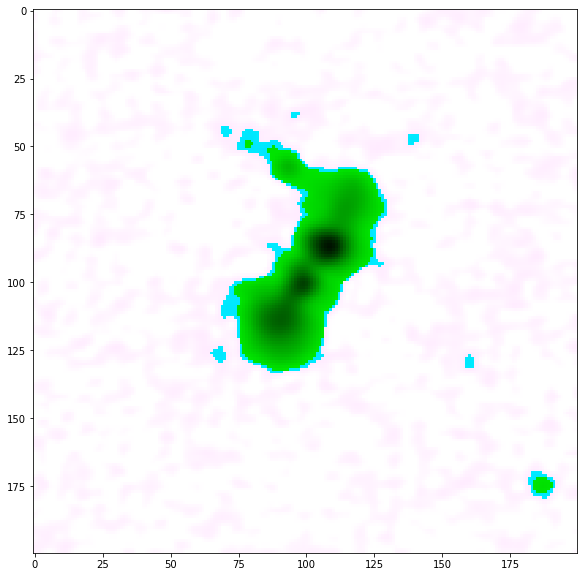

Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


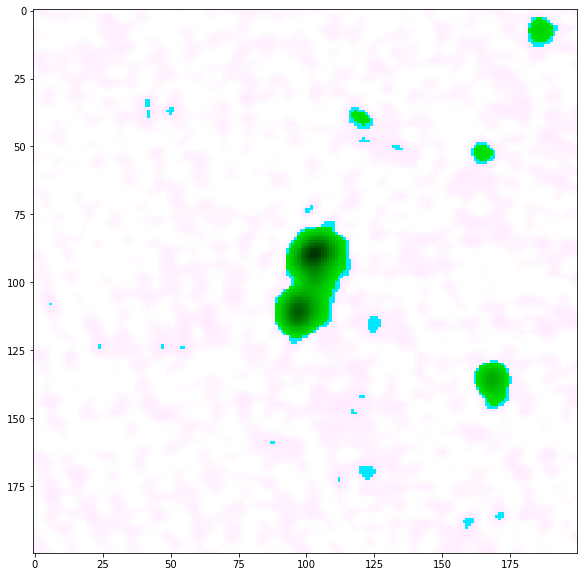

Instances(num_instances=0, image_height=200, image_width=200, fields=[pred_boxes, scores, pred_classes])


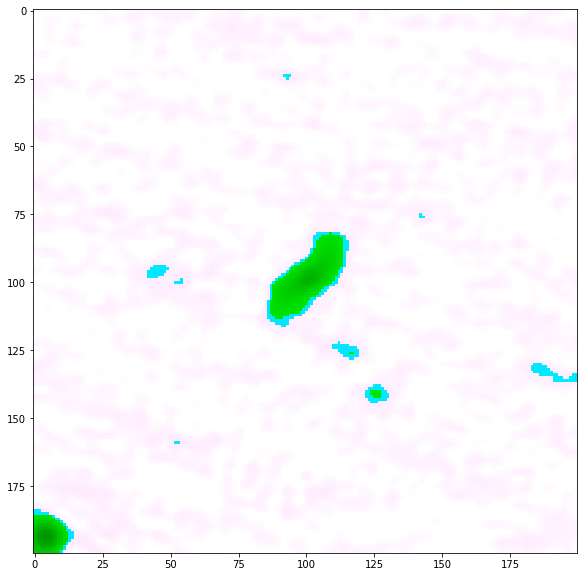

In [21]:
#Sample and plot predicted data as sanity check
aap = get_lofar_dicts(os.path.join(DATASET_PATH,f"VIA_json_val.pkl"))
for d in random.sample(aap, 3):
    if not d["file_name"].endswith('_rotated0deg.png'):
        continue
    im = imread(d["file_name"])
    outputs = predictor(im)
    print(outputs["instances"])
    v = Visualizer(im[:, :, ::-1],
                   metadata=lofar_metadata, 
                   scale=1, 
                  instance_mode=ColorMode.IMAGE #_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10,10))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.savefig(os.path.join(cfg.OUTPUT_DIR,f"random_prediction_example_for_sanity_check_{i}"))
    plt.show()
    plt.close()

In [22]:
# Evaluate performance for validation set
# returns a torch DataLoader, that loads the given detection dataset,
# with test-time transformation and batching.
# Val_loader produces inputs that can enter the model for inference,
# the results of which can be evaluated by the evaluator
# The return value is that which is returned by evaluator.evaluate()
val_loader = build_detection_test_loader(cfg, f"val")
evaluator = LOFAREvaluator(f"val", cfg.OUTPUT_DIR, distributed=True)
predictions = inference_on_dataset(trainer.model, val_loader, evaluator, overwrite=True)

[06/23 15:40:35 d2.data.build]: Distribution of instances among all 1 categories:
|   category   | #instances   |
|:------------:|:-------------|
| radio_source | 3537         |
|              |              |
[06/23 15:40:35 d2.evaluation.evaluator]: Start inference on 1298 images
[06/23 15:40:37 d2.evaluation.evaluator]: Inference done 11/1298. 0.1504 s / img. ETA=0:03:15
[06/23 15:40:47 d2.evaluation.evaluator]: Inference done 77/1298. 0.1504 s / img. ETA=0:03:06
[06/23 15:40:57 d2.evaluation.evaluator]: Inference done 143/1298. 0.1500 s / img. ETA=0:02:55
[06/23 15:41:07 d2.evaluation.evaluator]: Inference done 209/1298. 0.1499 s / img. ETA=0:02:45
[06/23 15:41:17 d2.evaluation.evaluator]: Inference done 275/1298. 0.1498 s / img. ETA=0:02:35
[06/23 15:41:27 d2.evaluation.evaluator]: Inference done 341/1298. 0.1498 s / img. ETA=0:02:25
[06/23 15:41:37 d2.evaluation.evaluator]: Inference done 406/1298. 0.1500 s / img. ETA=0:02:16
[06/23 15:41:47 d2.evaluation.evaluator]: Inference do

In [27]:
# Comment from Rafaël copied from train_lofar.py
"""
print("Evaluate performance for test set")
# returns a torch DataLoader, that loads the given detection dataset, 
# with test-time transformation and batching.
# Val_loader produces inputs that can enter the model for inference, 
# the results of which can be evaluated by the evaluator
# The return value is that which is returned by evaluator.evaluate()
val_loader = build_detection_test_loader(cfg, "test")
evaluator = LOFAREvaluator("test", cfg.OUTPUT_DIR, distributed=True)
predictions = inference_on_dataset(trainer.model, val_loader, evaluator, overwrite=True)
"""

'\nprint("Evaluate performance for test set")\n# returns a torch DataLoader, that loads the given detection dataset, \n# with test-time transformation and batching.\n# Val_loader produces inputs that can enter the model for inference, \n# the results of which can be evaluated by the evaluator\n# The return value is that which is returned by evaluator.evaluate()\nval_loader = build_detection_test_loader(cfg, "test")\nevaluator = LOFAREvaluator("test", cfg.OUTPUT_DIR, distributed=True)\npredictions = inference_on_dataset(trainer.model, val_loader, evaluator, overwrite=True)\n'